In [1]:
# ==============================================
# 1. Import Libraries
# ==============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import pickle

In [2]:
# ==============================================
# 2. Load Dataset
# ==============================================
df = pd.read_csv("heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


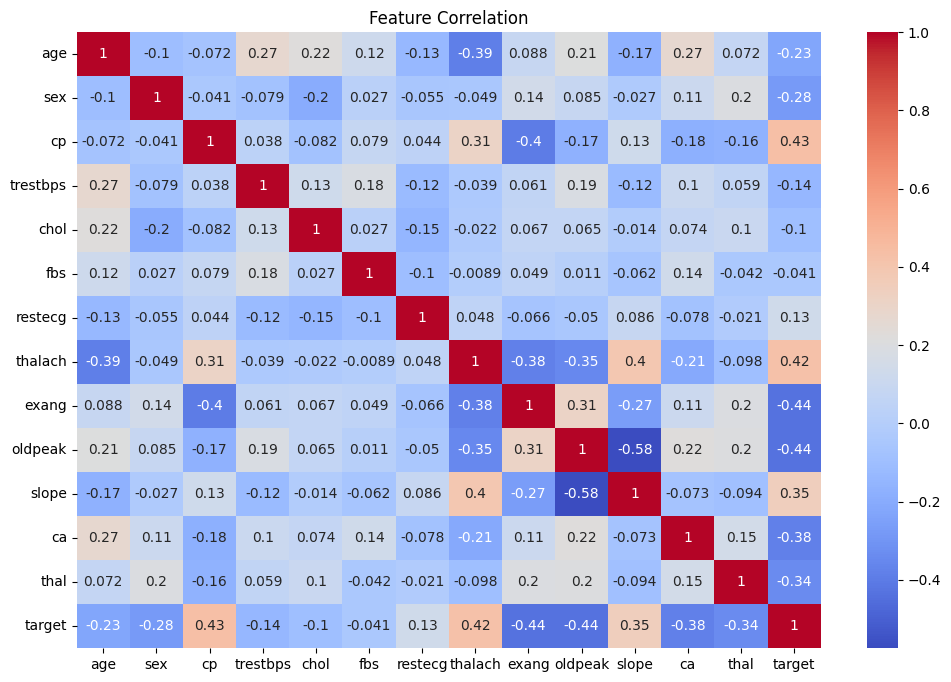

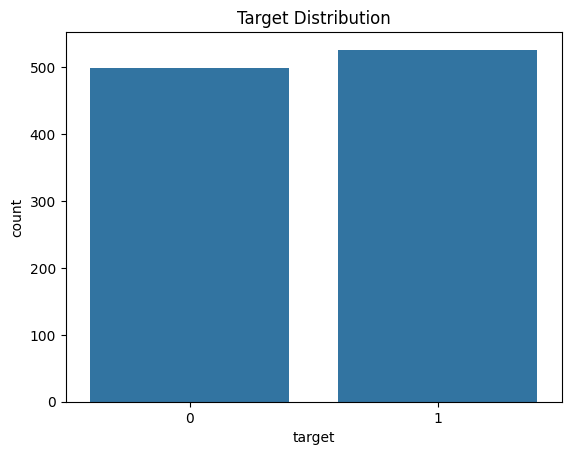

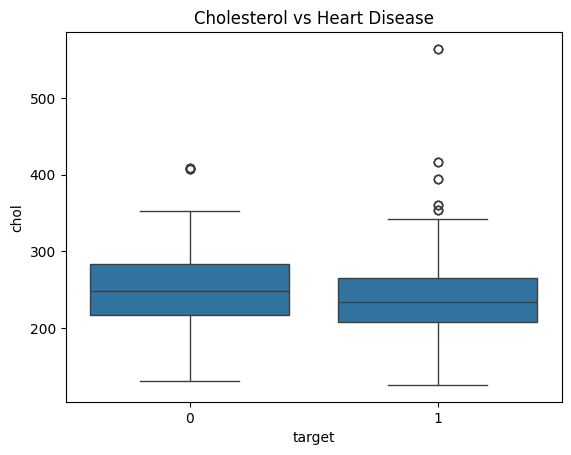

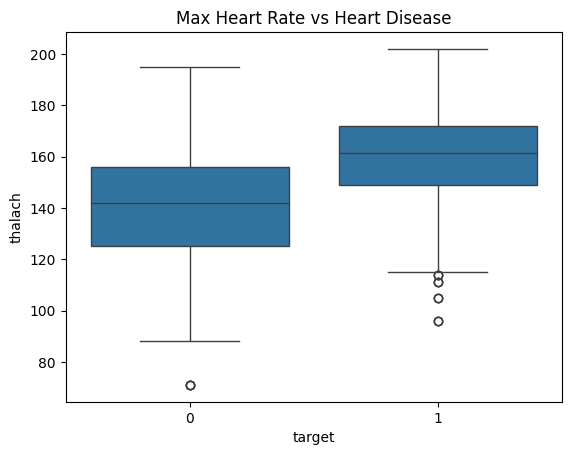

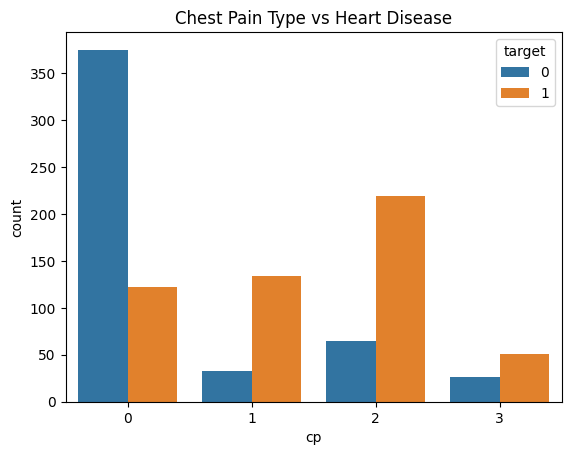

In [3]:
# ==============================================
# 3. Exploratory Data Analysis (EDA)
# ==============================================
# Check dataset info
df.info()

# Summary statistics
df.describe()

# Check null values
df.isnull().sum()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

# Distribution of target
sns.countplot(x='target', data=df)
plt.title("Target Distribution")
plt.show()

# High-impact feature visualizations
sns.boxplot(x='target', y='chol', data=df)
plt.title("Cholesterol vs Heart Disease")
plt.show()

sns.boxplot(x='target', y='thalach', data=df)
plt.title("Max Heart Rate vs Heart Disease")
plt.show()

sns.countplot(x='cp', hue='target', data=df)
plt.title("Chest Pain Type vs Heart Disease")
plt.show()

In [4]:
# ==============================================
# 4. Data Preprocessing & Feature Engineering
# ==============================================
# Encode categorical variables
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['cp'] = le.fit_transform(df['cp'])
df['thal'] = le.fit_transform(df['thal'])

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# ==============================================
# 5. Split Data into Train/Test
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


--- Training Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       102
           1       0.76      0.87      0.81       103

    accuracy                           0.80       205
   macro avg       0.80      0.79      0.79       205
weighted avg       0.80      0.80      0.79       205



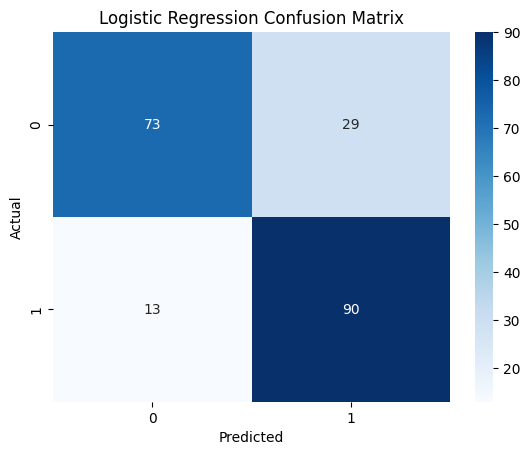

--- Training Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       102
           1       0.97      0.97      0.97       103

    accuracy                           0.97       205
   macro avg       0.97      0.97      0.97       205
weighted avg       0.97      0.97      0.97       205



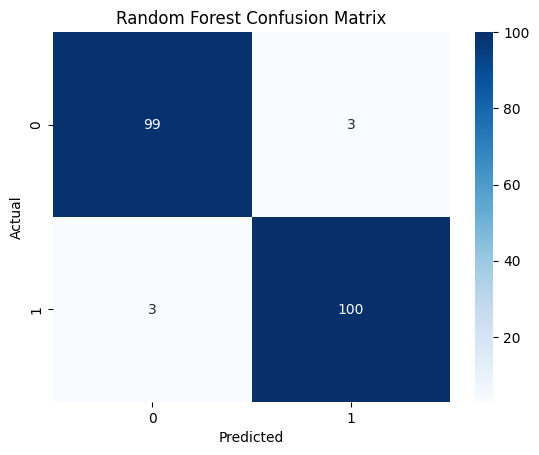

--- Training SVM ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.98      0.97      0.98       103

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



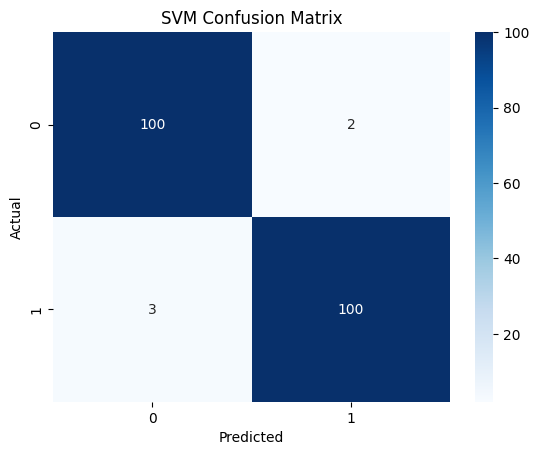

Logistic Regression - F1: 0.81, Recall: 0.87, Precision: 0.76
Random Forest - F1: 0.97, Recall: 0.97, Precision: 0.97
SVM - F1: 0.98, Recall: 0.97, Precision: 0.98

✅ Best model selected: SVM with F1-score = 0.98
SVC(C=10)


In [6]:
# ==============================================
# 6. Model Training & Hyperparameter Tuning
# ==============================================
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

params = {
    "Logistic Regression": {"C": [0.1, 1, 10]},
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [4, 6, 8]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
}

best_models = {}

for name in models:
    print(f"--- Training {name} ---")
    clf = GridSearchCV(models[name], params[name], cv=5, scoring='f1')
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    best_models[name] = clf.best_estimator_

# ==============================================
# 10. Evaluate All Models & Select the Best
# ==============================================
from sklearn.metrics import f1_score, recall_score, precision_score

model_metrics = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    model_metrics[name] = {"F1-score": f1, "Recall": recall, "Precision": precision}
    print(f"{name} - F1: {f1:.2f}, Recall: {recall:.2f}, Precision: {precision:.2f}")

# Select the best model based on highest F1-score
best_model_name = max(model_metrics, key=lambda x: model_metrics[x]['F1-score'])
best_model = best_models[best_model_name]

print(f"\n✅ Best model selected: {best_model_name} with F1-score = {model_metrics[best_model_name]['F1-score']:.2f}")
print(best_model)
# Save the best model (Random Forest)
pickle.dump(best_model, open("best_model.pkl", "wb"))

In [7]:
# ==============================================
# 7. Feature Importance (Random Forest)
# ==============================================
importances = best_model.feature_importances_
features = X.columns
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title("Feature Importance (Random Forest)")
plt.show()


AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [21]:
# ==============================================
# 8. Prediction Function
# ==============================================
def predict_heart_disease(model, input_data):
    input_array = np.array(input_data).reshape(1, -1)
    prediction = model.predict(input_array)
    return "Heart Disease Detected" if prediction[0]==1 else "No Heart Disease"

# Example usage
example_input = X_test[0]  # First test record
predict_heart_disease(best_model, example_input)

'Heart Disease Detected'

In [9]:
# ==============================================
# 9. Save Preprocessing Objects (Optional)
# ==============================================
# Save scaler for deployment
pickle.dump(scaler, open("scaler.pkl", "wb"))